# Gowalla
Gowalla is a location-based social network where users "check in" to various locations. A check-in is the action of recording a user's physical presence at a specific real-world location, and a spot is the digital representation of that real-world location within the network.  
The dataset contains friend links and a complete check-in history for each user (with geographic coordinates).

Dataset source: https://snap.stanford.edu/data/loc-Gowalla.html

---

This notebook focuses on building a real-world link prediction pipeline, introducing:
* Temporal Dynamics: Using a time-based split to predict future links based on past data.
* Large-Scale Data Handling: Applying efficient EDA and sampling techniques suitable for a larger graph.
* Node Embedding: Training Node2Vec to automatically learn feature representations from the graph structure.
* Advanced Feature Engineering: Combining topological features, engineered node attributes (from geographic check-in data), and learned embeddings.
* Model Comparison: Evaluating and comparing baseline models with more powerful ensemble models.

## Initialization

In [1]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import folium
from folium.plugins import HeatMap
from haversine import haversine_vector, Unit
import collections
import sys
import powerlaw
import random
from typing import Optional, List, Tuple, Set, Any, TypeVar, Hashable, Sequence

sys.path.append('../')

In [2]:
# Define dataset path
edges_path = 'data/Gowalla_edges.txt'
features_path = 'data/Gowalla_totalCheckins.txt'

In [3]:
# Create graph
G = nx.read_edgelist(edges_path, nodetype=int)

In [4]:
# Create feature dataframe
column_names = ['user', 'check-in_datetime', 'latitude', 'longitude', 'location_id']

try:
    df = pd.read_csv(features_path, sep='\t', names=column_names)
    df['check-in_datetime'] = pd.to_datetime(df['check-in_datetime'])

    print("DataFrame created successfully")

except FileNotFoundError:
    print(f"Error: The file '{features_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

# Downcast integer columns to save memory
df = df.astype({"user": np.int32, "location_id": np.int32})

DataFrame created successfully


### Functions Definition

In [5]:
def plot_distribution(data, title, xlabel, hist_bins=50, hist_y_log=True, hist_x_log=False, show_powerlaw=False):
    """
    ** For Discrete Data **
    Plots both a histogram with a log y-axis and a CCDF on a log-log scale.
    Optionally adds a power-law fit to the CCDF.
    """

    if isinstance(data, list):
        data = pd.Series(data)

    _, (plt1, plt2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Histogram with Log Y-axis
    plt1.hist(data, bins=hist_bins, color='skyblue', edgecolor='black')
    if hist_y_log:
        plt1.set_yscale('log')
    if hist_x_log:
        plt1.set_xscale('log')
    plt1.set_title(f'{title} (Histogram)', fontsize=16)
    plt1.set_xlabel(f'{xlabel} {"(Log Scale)" if hist_x_log else ""}', fontsize=14)
    plt1.set_ylabel(f'Frequency {"(Log Scale)" if hist_y_log else ""}', fontsize=14)
    plt1.grid(True, which="both", ls="--", linewidth=0.5)
    plt1.axvline(data.mean(), color='r', linestyle='--', label=f'Mean: {data.mean():.2f}')
    plt1.axvline(data.median(), color='g', linestyle='--', label=f'Median: {data.median():.2f}')
    plt1.legend()

    # Plot 2: CCDF on a Log-Log Scale
    raw_values = data.values
    total_count = len(raw_values)

    value_frequencies = collections.Counter(raw_values)
    sorted_values = sorted(value_frequencies.keys())
    value_counts = [value_frequencies[val] for val in sorted_values]

    cumulative_counts = np.cumsum(value_counts)
    ccdf_y = 1 - cumulative_counts / total_count

    plt2.loglog(sorted_values, ccdf_y, marker='o', linestyle='none', markersize=5, label='CCDF')

    # Add power-law fit
    if show_powerlaw:
        fit = powerlaw.Fit(raw_values, discrete=True, verbose=False)
        x_ccdf, _ = fit.ccdf()
        fit_line_y = fit.power_law.ccdf(x_ccdf)
        plt2.loglog(x_ccdf, fit_line_y, color='red', linestyle='-', linewidth=2,
                    label=f'Fitted Power-Law (α={fit.alpha:.2f}, xmin={int(fit.xmin)})') #type: ignore

    plt2.set_title(f'{title} (CCDF - Log-Log Scale)', fontsize=16)
    plt2.set_xlabel(xlabel, fontsize=14)
    plt2.set_ylabel('P(X ≥ k)', fontsize=14)
    plt2.grid(True, which="both", ls="--", linewidth=0.5)
    if show_powerlaw:
        plt2.legend(fontsize=12)

    plt.tight_layout()
    plt.show()


In [6]:
NodeType = TypeVar('NodeType', bound=Hashable)

def uniform_negative_sampling(
    node_list: List[NodeType],
    positive_edges: Set[frozenset],
    num_negative_samples: int,
    seed: Optional[int] = None
) -> List[Tuple[NodeType, NodeType]]:

    if seed is not None:
        random.seed(seed)

    attempts = 0
    max_attempts = num_negative_samples * 20 # TODO improvement: adaptive max_attempts based on graph density
    sampled_negatives = set()

    while len(sampled_negatives) < num_negative_samples and attempts < max_attempts:
        u, v = random.sample(node_list, 2)
        pair = frozenset((u, v))

        if pair not in positive_edges and pair not in sampled_negatives:
            sampled_negatives.add(pair)
        attempts += 1

    if len(sampled_negatives) < num_negative_samples:
        raise RuntimeError(f"Could only sample {len(sampled_negatives)} unique negative pairs after {attempts} attempts.")

    return [tuple(edge) for edge in sampled_negatives]

## Exploratory Data Analysis (EDA)

### Graph Topology

In [7]:
density = nx.density(G)
degrees = [d for _, d in G.degree()]

print(G)
print(f'Average degree: {np.mean(degrees):.1f}')
print(f'Max degree: {np.max(degrees)}')
print(f'Min degree: {np.min(degrees)}')
print(f'Density: {density:.8f}')

Graph with 196591 nodes and 950327 edges
Average degree: 9.7
Max degree: 14730
Min degree: 1
Density: 0.00004918


In [8]:
# Connected Components
print("Number of connected components:", nx.number_connected_components(G))

Number of connected components: 1


In [9]:
# Clustering
# NOTE: Computationally intensive
print(f'Average Local Clustering: {nx.average_clustering(G):.4f}')
print(f'Transitivity: {nx.transitivity(G):.4f}')

Average Local Clustering: 0.2367
Transitivity: 0.0235


In [10]:
# Calculating Diameter is infeasible with a graph this large
# We can take the measure directly from the SNAP dataset page
print('Diameter: 14')
print('90-percentile effective diameter: 5.7')

Diameter: 14
90-percentile effective diameter: 5.7


In [11]:
# Assortativity
print(f'Degree Assortativity: {nx.degree_assortativity_coefficient(G):.2f}')

Degree Assortativity: -0.03


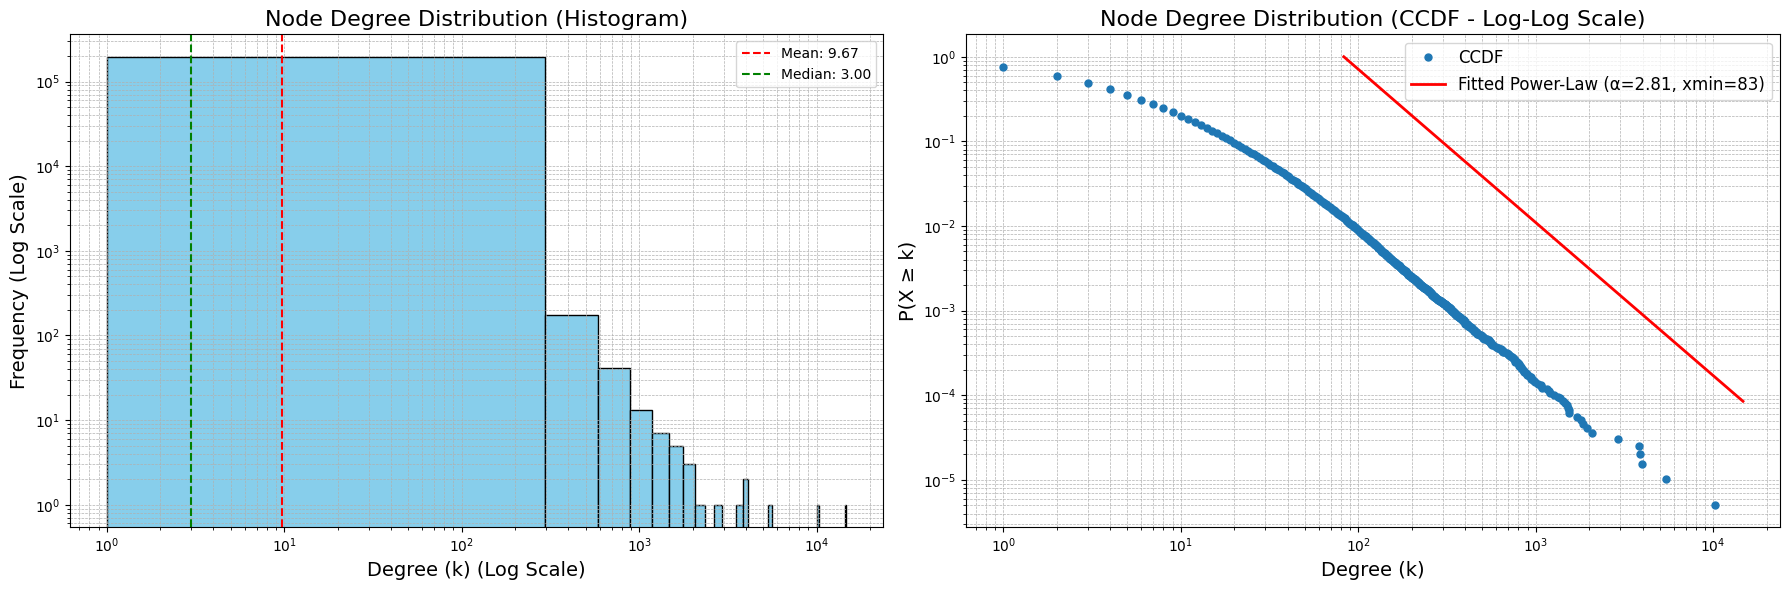

In [12]:
degrees = [G.degree(n) for n in G.nodes()]
plot_distribution(degrees, 'Node Degree Distribution', 'Degree (k)', hist_x_log=True, show_powerlaw=True)

#### Insights

**Size**  
With ~200 000 nodes (users) and ~1 000 000 connections (friendships between users) this is an extremely sparse network.

**Connected Components**  
The entire network is a single connected component, which is somewhat unusual to have in a social network. The data, as reported in the SNAP dedicated page, has been collected from the Gowalla public API, and is not reported if the dataset include only a connected component. According to sources<sup>[[1][1]] [[2][2]]</sup>, by late 2010 Gowalla had approximately 600 000 members, which could confirm the hypothesis that the dataset is reporting only a connected component (probably the largest). Further investigation will be done by inspecting the number of edges of new users over time. <span style="color:yellow">(TODO)</span>

[1]: https://web.archive.org/web/20101205020126/http://content.usatoday.com/communities/technologylive/post/2010/12/the-latest-from-gowalla-is-worth-checking-out/1
[2]: https://en.wikipedia.org/wiki/Gowalla

**Degree**  
The degree analysis reported an heavy-tailed degree distribution with many users that have a low degree and some hubs that have over 10 000 connections. The Complementary Cumulative Distribution Function (CCDF) with Log-Log scale plotted a straight line, confirming the presence of a power law (for degree values >= 83).

**Clustering**  
There is a moderate (~23%) probability that two friends of a user are also friends with each other, confirming the presence of tight local cluster, while the global structure is loosely connected.

**Distances**  
A diameter of 14 and a 90th percentile of ~6 indicates the presence of a small-world property.

### Check-Ins Features

In [13]:
df.head()

,user,check-in_datetime,latitude,longitude,location_id
0,0,2010-10-19 23:55:27+00:00,30.235909,-97.795140,22847
1,0,2010-10-18 22:17:43+00:00,30.269103,-97.749395,420315
2,0,2010-10-17 23:42:03+00:00,30.255731,-97.763386,316637
3,0,2010-10-17 19:26:05+00:00,30.263418,-97.757597,16516
4,0,2010-10-16 18:50:42+00:00,30.274292,-97.740523,5535878


In [14]:
print(f'DataFrame with {df.shape[0]} rows and {df.shape[1]} columns')

print('\nDataframe info:')
print(df.info(memory_usage='deep'))

DataFrame with 6442892 rows and 5 columns

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6442892 entries, 0 to 6442891
Data columns (total 5 columns):
 #   Column             Dtype              
---  ------             -----              
 0   user               int32              
 1   check-in_datetime  datetime64[ns, UTC]
 2   latitude           float64            
 3   longitude          float64            
 4   location_id        int32              
dtypes: datetime64[ns, UTC](1), float64(2), int32(2)
memory usage: 196.6 MB
None


In [15]:
df.isna().sum()

user                 0
check-in_datetime    0
latitude             0
longitude            0
location_id          0
dtype: int64

#### Locations and Coordinates Sanity Check

Before using the geographic data, we must ensure its integrity. 

In [16]:
# Check the range of the coordinates
print(f"Latitude range: {df['latitude'].min():.10f} to {df['latitude'].max():.10f}")
print(f"Longitude range: {df['longitude'].min():.10f} to {df['longitude'].max():.10f}")

Latitude range: -90.0000000000 to 405.6584980000
Longitude range: -176.3085937500 to 177.4624907970


In [17]:
# Filter the range
original_rows = len(df)

lat_min, lat_max = -90, 90
lon_min, lon_max = -180, 180

valid_coords = (df['latitude'].between(lat_min, lat_max)) & (df['longitude'].between(lon_min, lon_max))

df = df[valid_coords].copy()

rows_removed = original_rows - len(df)

print(f"Removed {rows_removed} rows with invalid coordinates ({(rows_removed / original_rows) * 100:.2f}% of total).")

Removed 29 rows with invalid coordinates (0.00% of total).


In [18]:
# Check the relation cardinality between Locations-Coordinates
unique_coords_for_each_location = df.groupby('location_id')[['latitude', 'longitude']].nunique().max(axis=1).loc[lambda x: x > 1]
unique_location_for_each_coord = df.groupby(['latitude', 'longitude'])['location_id'].nunique().loc[lambda x: x > 1]

print(f'There are {len(unique_coords_for_each_location)} locations with multiple coordinates associated.')
print(f'There are {len(unique_location_for_each_coord)} coordinates with multiple locations associated.')

There are 297 locations with multiple coordinates associated.
There are 17120 coordinates with multiple locations associated.


This finding is critical: there is a **many-to-many** association between locations and coordinates. This means that at the moment the location is not a perfect information to define a unique physical "place" in the real world.
The reasons behind this discrepancy could be multiple:
- GPS inaccuracy.
- A large location (like an airport or a park) could have been represented with different coordinates.
- Locations could have moved to a different position, resulting in different coordinates over time.
- If coordinates are user generated and not linked to a location by Gowalla itself, multiple users could have created multiple coordinates for the same place.
- Two locations that extends vertically in the same building will have the same coordinates.

It's also worth to node that each decimal place in a coordinate adds about a magnitude more precision. This means that if each decimal degree is equal to 111 kilometers at the equator, a value in decimal degrees with a precision of 4 decimal places is precise to 11.1 metres at the equator, and a value in decimal degrees with a precision of 10 decimal places is precise to ~11 micrometers at the equator<sup>[[1][1]]</sup>: this is how the data is represented in the dataset. Is safe to say that no GPS has this precision, and the data provided could have been subject to *computation artifacts* (floating-point).

To create reliable location-based features we need a single coordinate for each `location_id`. We'll define this as the **modal coordinate**: the most frequently checked-in (latitude, longitude) pair for that location.

[1]: <https://en.wikipedia.org/wiki/Decimal_degrees#Precision>

In [19]:
# Find the most frequent (modal) coordinate for each location
most_frequent_coords = df.groupby(['location_id', 'latitude', 'longitude'])\
    .size()\
    .reset_index(name='count')\
    .sort_values('count', ascending=False)\
    .drop_duplicates(subset='location_id')\
    .set_index('location_id')\
    .rename(columns={'latitude': 'modal_lat', 'longitude': 'modal_lon'})\
    [['modal_lat', 'modal_lon']]

# Chain operations to create the final locations_df
locations_df = (
    df.join(most_frequent_coords, on='location_id')
    .assign(
        lat_mode_deviation=lambda x: (x['latitude'] - x['modal_lat']).abs(),
        lon_mode_deviation=lambda x: (x['longitude'] - x['modal_lon']).abs()
    )
    .groupby('location_id')
    .agg(
        checkin_count=('user', 'size'),
        most_frequent_lat=('modal_lat', 'first'),
        most_frequent_lon=('modal_lon', 'first'),
        lat_mode_deviation=('lat_mode_deviation', 'mean'),
        lon_mode_deviation=('lon_mode_deviation', 'mean')
    )
)

In [20]:
# Extract locations with deviation
locations_with_deviation = locations_df[(locations_df['lat_mode_deviation'] != 0) | (locations_df['lon_mode_deviation'] != 0)]

print(f"There are {locations_with_deviation.shape[0]} ({len(locations_with_deviation)/len(locations_df)*100:.2f}%) "
       "locations with coordinates that deviates from their most frequent position.\n"
      f"Those locations appears in {len(df[df['location_id'].isin(locations_with_deviation.index.to_series())])} checkins total."
)

locations_df.sort_values(by=['lat_mode_deviation', 'lon_mode_deviation'], ascending=False).head()

There are 297 (0.02%) locations with coordinates that deviates from their most frequent position.
Those locations appears in 6360 checkins total.


,checkin_count,most_frequent_lat,most_frequent_lon,lat_mode_deviation,lon_mode_deviation
location_id,,,,,
5346854,9,34.847950,-82.401950,1.160431,0.372884
4242925,2,-6.182966,106.830647,0.017364,0.003111
479809,9,40.505185,-86.184998,0.012101,0.025099
3799363,6,39.879822,-75.248274,0.010054,0.002449
1203730,2,29.815700,-95.673752,0.006843,0.001709


#### Check-in Temporal & Geographical Distribution

The check-in data allows to infer more nuanced behavioral patterns that could reveal strong indicators of social connection.

Data ranges from 2009-02-04 05:17:38+00:00 to 2010-10-23 05:22:06+00:00


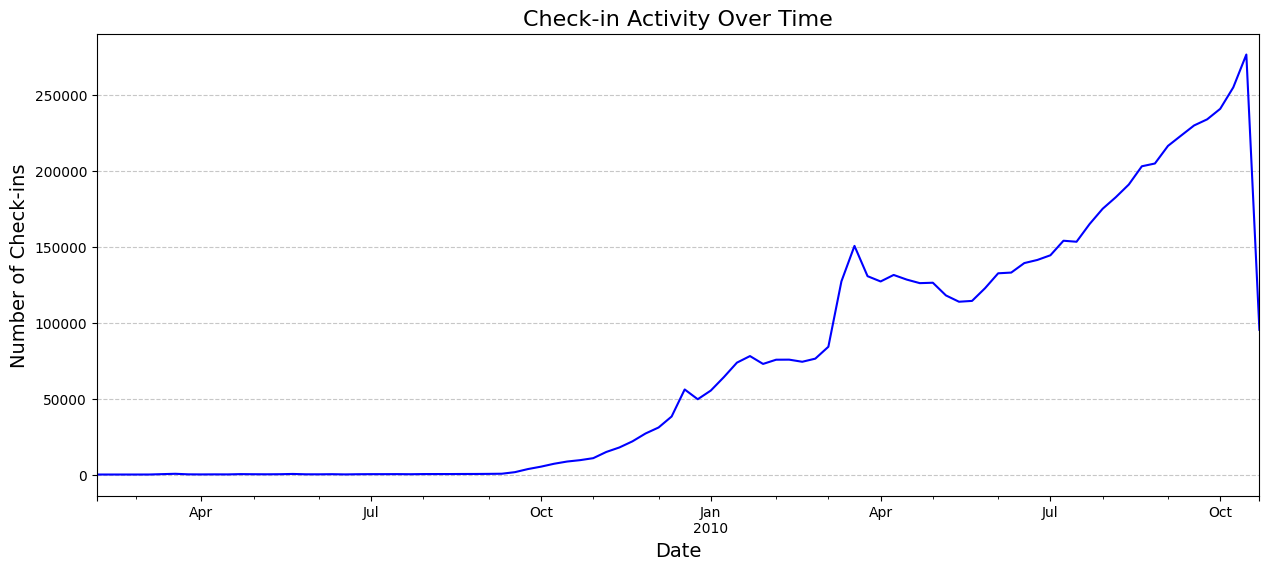

In [21]:
df_time = df.set_index('check-in_datetime')

# Count the number of check-ins (per week)
checkins_over_time = df_time.resample('W').size()

# Plotting
plt.figure(figsize=(15, 6))
checkins_over_time.plot(color='b')

plt.title('Check-in Activity Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Check-ins', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

print(f"Data ranges from {df['check-in_datetime'].min()} to {df['check-in_datetime'].max()}")
plt.show()

In [22]:
# Check-in heatmap (saved locally)
heat_data = df[['latitude', 'longitude']].values.tolist()

map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

HeatMap(heat_data, radius=15, blur=10).add_to(m)

m.save("gowalla_heatmap.html")

Number of users with at least one check-in: 107092 (54.47%)
Most active user made 2175 check-ins.
Average user has ~60.16 check-ins.



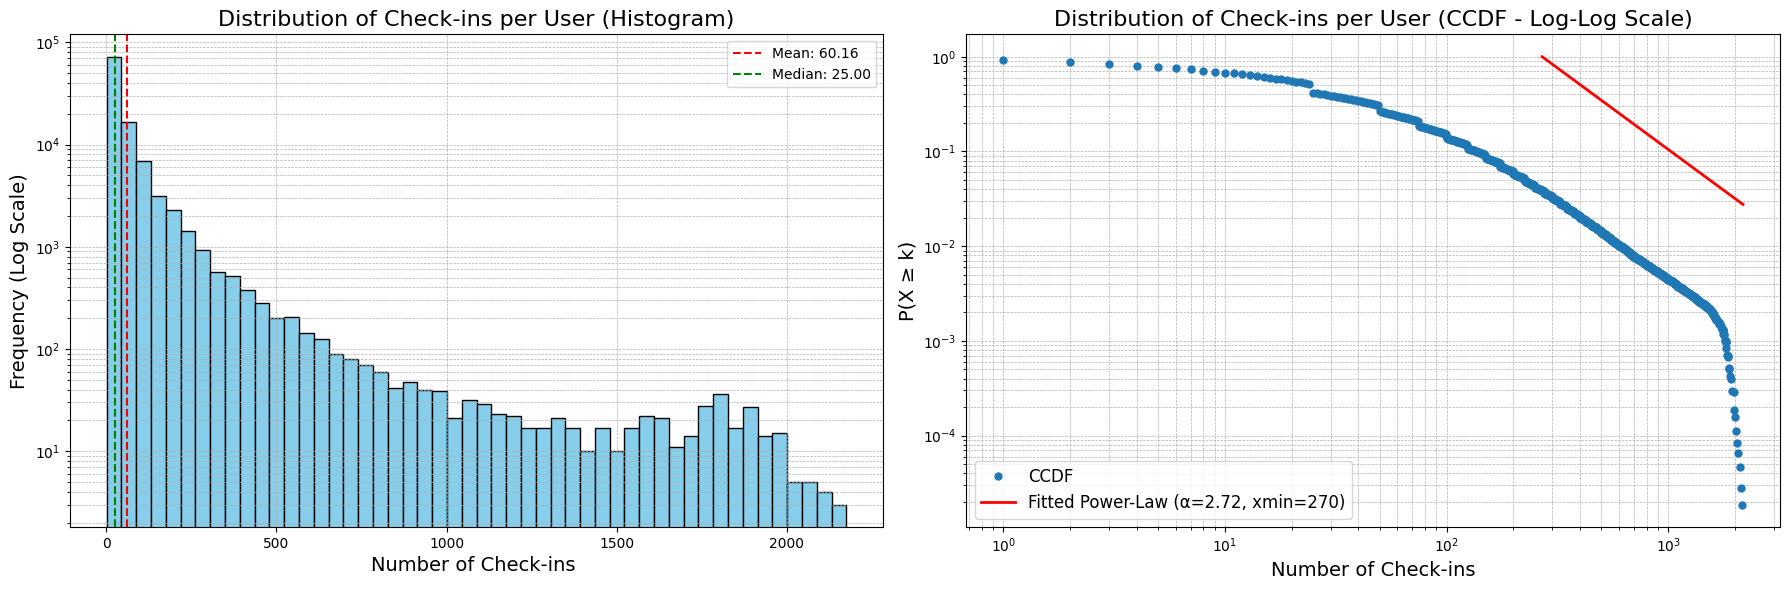

In [23]:
# Distribution of Check-ins per User
checkins_per_user = df['user'].value_counts()

print(f'Number of users with at least one check-in: {len(checkins_per_user)} ({len(checkins_per_user)/G.number_of_nodes()*100:.2f}%)')
print(f'Most active user made {checkins_per_user.max()} check-ins.')
print(f'Average user has ~{checkins_per_user.mean():.2f} check-ins.\n')


plot_distribution(
    checkins_per_user,
    'Distribution of Check-ins per User',
    'Number of Check-ins',
    show_powerlaw=True
)

Unique locations:               1280956
Most check-ins for a location:  5811
Average check-ins per location: 5.03
Median check-ins per location:  2.00
Least check-ins for a location: 1




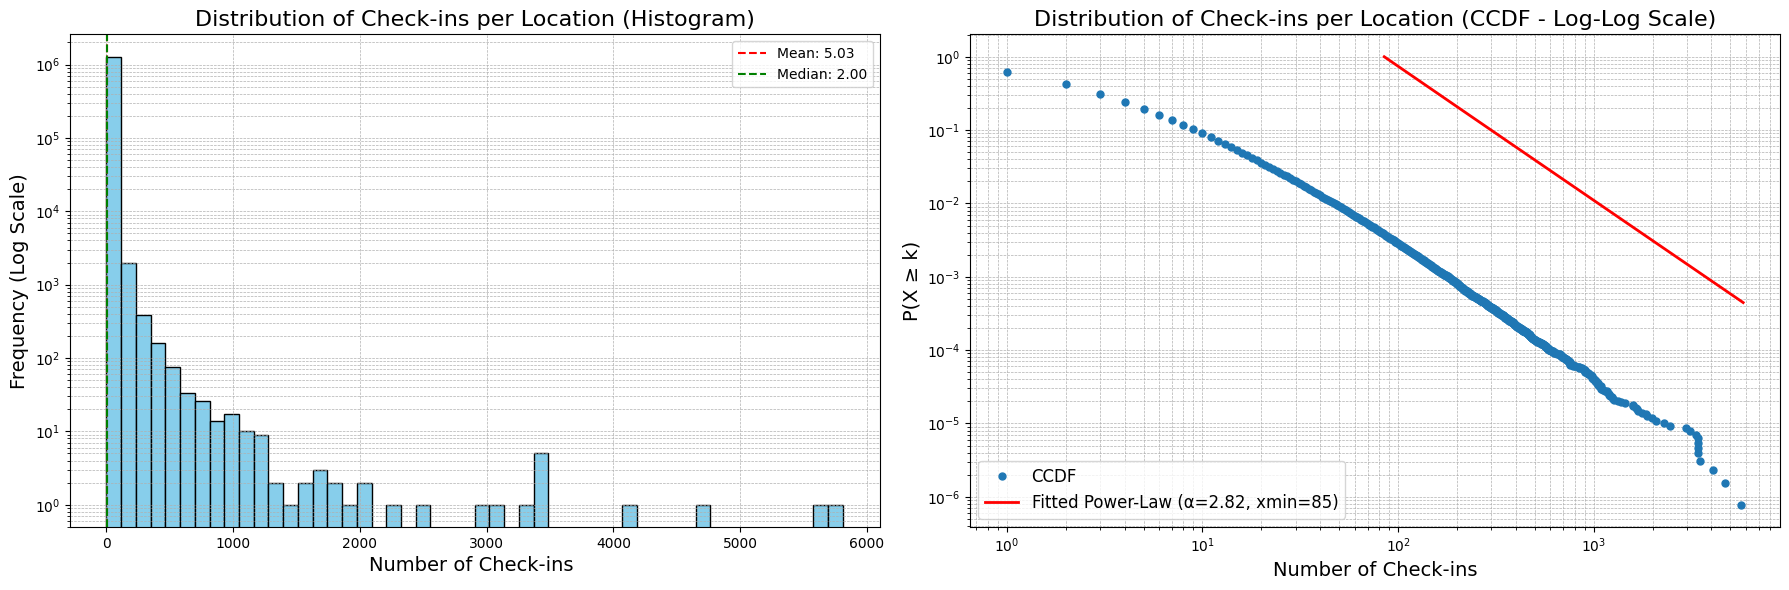

In [24]:
# Distribution of Check-ins per Locations
checkins_per_location = df['location_id'].value_counts()

print(f'Unique locations:               {len(checkins_per_location)}')
print(f'Most check-ins for a location:  {checkins_per_location.max()}')
print(f'Average check-ins per location: {checkins_per_location.mean():.2f}')
print(f'Median check-ins per location:  {checkins_per_location.median():.2f}')
print(f'Least check-ins for a location: {checkins_per_location.min()}')

print('\n')
plot_distribution(
    checkins_per_location,
    'Distribution of Check-ins per Location',
    'Number of Check-ins',
    show_powerlaw=True
)

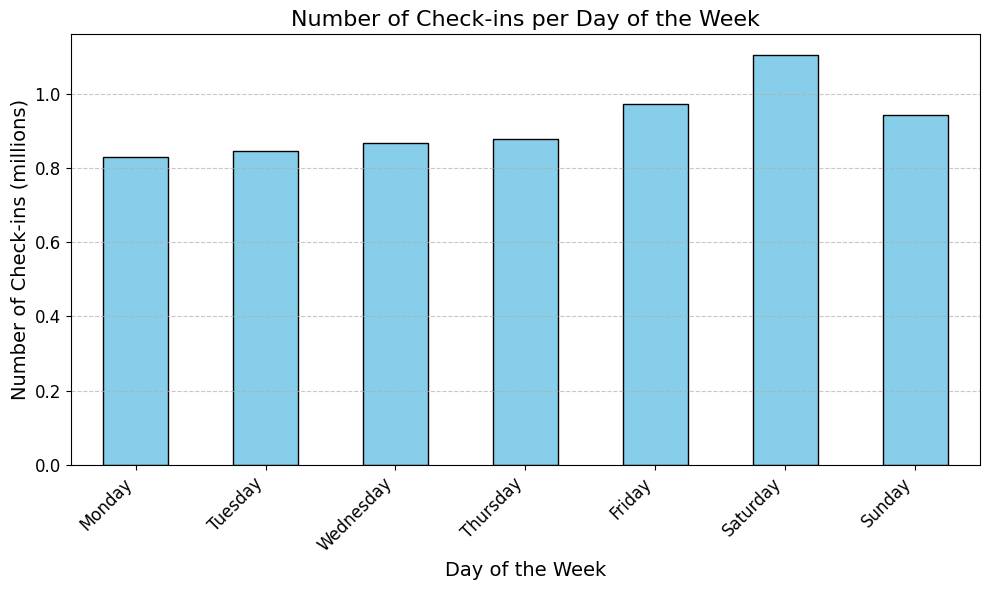

In [25]:
# Number of Check-ins per Day of the Week
df['day_of_week'] = df['check-in_datetime'].dt.dayofweek

# Count check-ins for each day of the week
checkins_by_day = df['day_of_week'].value_counts().sort_index()
checkins_by_day = checkins_by_day / 1000000

# Map numerical day of week to names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
checkins_by_day.index = [day_names[i] for i in checkins_by_day.index] #type: ignore

# Plotting
plt.figure(figsize=(10, 6))
checkins_by_day.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Check-ins per Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Check-ins (millions)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12) # Rotate labels for readability
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Only horizontal grid lines
plt.tight_layout()
plt.show()

df = df.drop(columns=['day_of_week'])

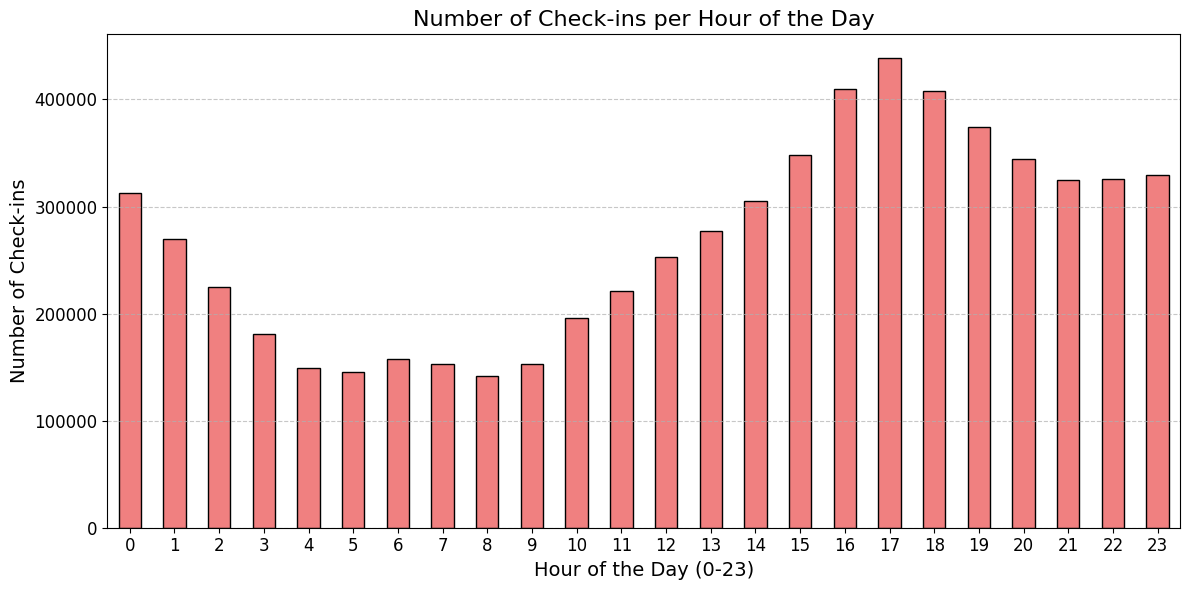

In [26]:
# Number of Check-ins per Hour of the Day
df['hour_of_day'] = df['check-in_datetime'].dt.hour

# Count check-ins for each hour of the day
checkins_by_hour = df['hour_of_day'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
checkins_by_hour.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Number of Check-ins per Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (0-23)', fontsize=14)
plt.ylabel('Number of Check-ins', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Only horizontal grid lines
plt.tight_layout()
plt.show()

df = df.drop(columns=['hour_of_day'])

#### Insights

**Locations and Coordinates Relation**
The first thing to notice is that coordinates have up to 10 decimal numbers, that is clearly an artifact of some kind as already explained. This high-precision numbers are part of a bigger problem: the many-to-many relation between coordinates and locations. To work safely we need to position each location in a unique position. This has been achieved by taking the mode (most frequent value) of coordinate for each location. The result had only 297 location which had high deviation from the mode: the highest had a massive average latitude deviation of 1.16, which is over 100km. Those locations could be removed as they are a small fraction of the total dataset, but are also a part of (noisy) information that could still have some prediction power.

**Date and Time Continuity**
The graph "Check-in Activity Over Time" clearly shows activity starting in late 2009, rising to a peak around late 2010, where the dataset snapshot stops. The data is continuous, with no major gaps, and have a slow start that takes 1/3 of total coverage. This plot provides a good visualization of a temporal train/test split.

**Distribution of Checkins**
The "*Distribution of Check-ins per User*" plot clearly shows the presence of super-users. Also it's important to note that less than half of total users have at least one check-in registered, meaning that for the remaining half only the graph topological structure could be used to predict friendship. The "*Distribution of Check-ins per Location*" plot also shows the presence of super-locations.

The bar chart "*Check-ins per Day of the Week*" shows a weekly cycle, with activity peaking on Fridays and Saturdays and being lowest on Monday. The bar chart "*Check-ins per Hour of the Day*" shows that there is also a cycle withing the hours with the peak reached at 5 PM and the lull in the early morning. This helps to assure the realism of the dataset, because it represents the real human behavioral patterns.

#### Home Location Inference

The goal here is to infer the user's home locations from GPS tracking of their movements trough check-in. The idea is that friends are more likely to be geographically close, i.e. if their inferred homes are close. 

There are different ways to infer a user home:
- **Overall Centroid**: The median of all check-in coordinates. This represents a user's general center of activity.
- **Heuristic-Based Method**: Using heuristics and common sense assumptions.
- **Grid-Based Methods**

TODO-IDEA: follow-up "Mobility Analysis" notebook implementing more methods. Use pipelining libraries to save results. 


**Centroid Calculation**

In [27]:
# Create a Users Dataframe and calculate median of coordinates
users_df = df.groupby('user').agg(
    checkin_count=('user', 'count'),
    median_centroid_latitude=('latitude', 'median'),
    median_centroid_longitude=('longitude', 'median')
)

**Heuristic-Based Method**  
This method is based on the assumption that people spend the most time at (and frequently visit) their home and work locations. This two location can be differentiated by the time of the day: the home will have check-ins made at night and early morning hours (10 PM - 6 AM), while work on weekdays and during common working hours (9 AM - 5 PM).

In [28]:
# Helper function
def _get_most_frequent_location(dataframe: pd.DataFrame, filter_mask: pd.Series) -> pd.Series:
    """Filters a dataframe by a boolean mask and finds the most frequent location_id for each user."""
    return (
        dataframe[filter_mask]
        .groupby(['user', 'location_id'])
        .size()
        .reset_index(name='count')
        .sort_values('count', ascending=False)
        .drop_duplicates(subset='user')
        .set_index('user')['location_id']
    )

In [29]:
# Heuristic to infer Home Locations
home_hours = (df['check-in_datetime'].dt.hour >= 21) | (df['check-in_datetime'].dt.hour < 7) # Slightly wider window (9 PM - 7 AM)

users_df = users_df.join(
    _get_most_frequent_location(df, home_hours).rename('inferred_home_location_id')
)

In [30]:
# Show results
home_hours_users_count = users_df['inferred_home_location_id'].notna().sum()

print(f"There are {len(df[home_hours])} ({len(df[home_hours])/len(df)*100:.2f}%) "
       "check-ins made during home hours (9 PM - 7 AM)."
)
print(f"There are {home_hours_users_count} ({home_hours_users_count/len(users_df)*100:.2f}%) "
       "users that have checked-in during home hours (9 PM - 7 AM)."
)

There are 2420498 (37.57%) check-ins made during home hours (9 PM - 7 AM).
There are 91013 (84.99%) users that have checked-in during home hours (9 PM - 7 AM).


In [31]:
# Heuristic to infer Work Locations
weekdays = df['check-in_datetime'].dt.dayofweek < 5 # Monday to Friday
work_hours = (df['check-in_datetime'].dt.hour >= 9) & (df['check-in_datetime'].dt.hour < 17) # (9 AM - 17 PM)

users_df = users_df.join(
    _get_most_frequent_location(df, (work_hours & weekdays)).rename('inferred_work_location_id')
)

In [32]:
# Show result
work_hours_users_count = users_df['inferred_work_location_id'].notna().sum()

print(f"There are {len(df[work_hours & weekdays])} ({len(df[work_hours & weekdays])/len(df)*100:.2f}%) "
       "check-ins made during work hours (9 AM - 17 PM, Mon - Fri)."
)
print(f"There are {work_hours_users_count} ({work_hours_users_count/len(users_df)*100:.2f}%) "
       "users that have checked-in during work hours (9 AM - 17 PM, Mon - Fri)."
)

There are 1520105 (23.59%) check-ins made during work hours (9 AM - 17 PM, Mon - Fri).
There are 84866 (79.25%) users that have checked-in during work hours (9 AM - 17 PM, Mon - Fri).


**Grid-Based Method**  
The core idea is to overlay a grid of fixed dimension on the map (**spacial discretization**) and count points in each cell: the most visited cell for each user should contain the user's home.   
This method should be able to easily handle the noisy coordinates we found in the original dataset.

As the cell dimensions i initially thought of a 100 by 100 meters cell, but analyzing the paper present into the dataset SNAP page, i found out that they also used grid discretization, but with a cell 25x25 Kilometers, which inferred home locations with 85% accuracy. It's clear that using my grid size the accuracy would have been extremely low, so i'll use the literature chosen size.  

In [33]:
# The grid will have 25x25 Kilometers cells
lat_step, lon_step = 0.25, 0.25
df['lat_bin'] = (df['latitude'] / lat_step).astype(int)
df['lon_bin'] = (df['longitude'] / lon_step).astype(int)

# Find the most visited grid cell for each user during home hours
home_cells = df[home_hours]\
    .groupby(['user', 'lat_bin', 'lon_bin'])\
    .size()\
    .reset_index(name='count')\
    .sort_values('count', ascending=False)\
    .drop_duplicates(subset='user')\
    .set_index('user')\
    [['lat_bin', 'lon_bin']]\
    .rename(columns={'lat_bin': 'home_lat_bin', 'lon_bin': 'home_lon_bin'})

# Chain operations to calculate the centroid of check-ins within each user's home cell
home_cell_centroids = (
    df.join(home_cells, on='user')
    .dropna(subset=['home_lat_bin'])
    .query('lat_bin == home_lat_bin and lon_bin == home_lon_bin')
    .groupby('user')
    .agg(
        home_cell_centroid_lat=('latitude', 'median'),
        home_cell_centroid_lon=('longitude', 'median')
    )
)

users_df = users_df.join(home_cell_centroids)

In [34]:
# Final Result
users_df.head()

,checkin_count,median_centroid_latitude,median_centroid_longitude,inferred_home_location_id,inferred_work_location_id,home_cell_centroid_lat,home_cell_centroid_lon
user,,,,,,,
0,225,30.269103,-97.749395,420315.0,420315.0,30.269103,-97.749312
1,12,46.215364,5.386916,1441698.0,1395104.0,44.724746,5.032961
2,2100,34.150619,-118.469616,1014659.0,59838.0,37.866430,-122.262936
4,225,37.783715,-122.403858,57155.0,57155.0,37.786479,-122.403563
5,50,30.288773,-97.728501,22535.0,22535.0,30.281845,-97.727924


##### Comparing Home Inference Methods

Let's compare the results. I expect the home location to be close to the user's overall center of activity (the median centroid). We can just measure the distance between the centroid and the locations found by the two more advanced methods.

In [35]:
# Create a new data with only the columns needed and cleaned
users_home_location_df = users_df.dropna(
    subset=['median_centroid_latitude', 'inferred_home_location_id', 'home_cell_centroid_lat']
).copy()

inferred_home_coords = locations_df[['most_frequent_lat', 'most_frequent_lon']].rename(
    columns={'most_frequent_lat': 'inferred_home_lat', 'most_frequent_lon': 'inferred_home_lon'}
)

users_home_location_df = users_home_location_df.join(
    inferred_home_coords, on='inferred_home_location_id'
).dropna(subset=['inferred_home_lat'])

In [36]:
# Calculate the Haversine Distance (vectorized for efficiency)
coords_centroid = users_home_location_df[['median_centroid_latitude', 'median_centroid_longitude']].to_numpy()
coords_inferred_home = users_home_location_df[['inferred_home_lat', 'inferred_home_lon']].to_numpy()
coords_home_cell = users_home_location_df[['home_cell_centroid_lat', 'home_cell_centroid_lon']].to_numpy()

users_home_location_df['centroid_inferred_home_distance_km'] = haversine_vector(
    coords_centroid, coords_inferred_home, unit=Unit.KILOMETERS
)
users_home_location_df['centroid_home_cell_distance_km'] = haversine_vector(
    coords_centroid, coords_home_cell, unit=Unit.KILOMETERS
)

Centroid to Heuristically Inferred Home
  % of values < 1km: 32.2%
  % of values < 5km: 58.0%
  % of values < 10km: 69.6%
Centroid to Home Cell
  % of values < 1km: 49.2%
  % of values < 5km: 69.1%
  % of values < 10km: 76.7%


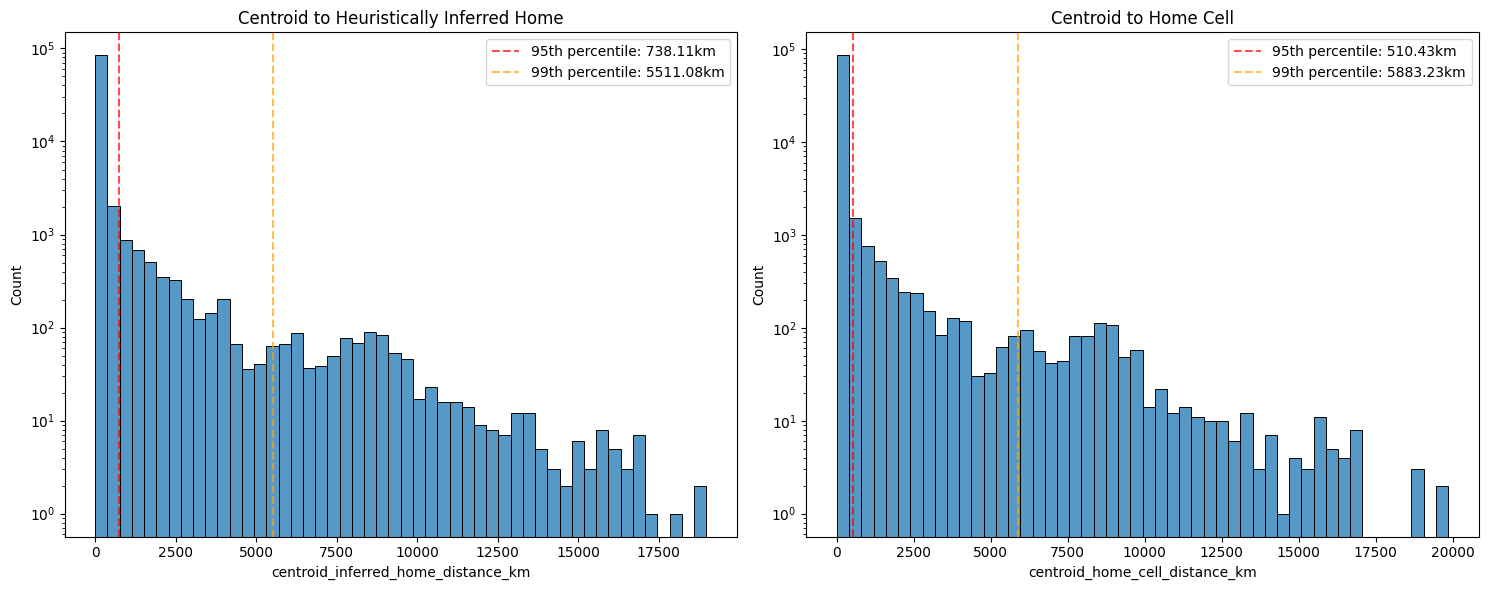

In [37]:
# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calculate percentiles
p95_1 = np.percentile(users_home_location_df['centroid_inferred_home_distance_km'], 95)
p99_1 = np.percentile(users_home_location_df['centroid_inferred_home_distance_km'], 99)
p95_2 = np.percentile(users_home_location_df['centroid_home_cell_distance_km'], 95)
p99_2 = np.percentile(users_home_location_df['centroid_home_cell_distance_km'], 99)

# Centroid to Inferred Home
sns.histplot(data=users_home_location_df,
             x='centroid_inferred_home_distance_km',
             bins=50, kde=False, ax=axes[0])
axes[0].set_yscale('log')
axes[0].axvline(p95_1, color='red', linestyle='--', alpha=0.7, label=f'95th percentile: {p95_1:.2f}km')
axes[0].axvline(p99_1, color='orange', linestyle='--', alpha=0.7, label=f'99th percentile: {p99_1:.2f}km')
axes[0].set_title('Centroid to Heuristically Inferred Home')
axes[0].legend()

# Centroid to Home Cell
sns.histplot(data=users_home_location_df,
             x='centroid_home_cell_distance_km',
             bins=50, kde=False, ax=axes[1])
axes[1].set_yscale('log')
axes[1].axvline(p95_2, color='red', linestyle='--', alpha=0.7, label=f'95th percentile: {p95_2:.2f}km')
axes[1].axvline(p99_2, color='orange', linestyle='--', alpha=0.7, label=f'99th percentile: {p99_2:.2f}km')
axes[1].set_title('Centroid to Home Cell')
axes[1].legend()

# Print statistics
data = users_home_location_df['centroid_inferred_home_distance_km']
print('Centroid to Heuristically Inferred Home')
print(f"  % of values < 1km: {(data < 1).mean()*100:.1f}%")
print(f"  % of values < 5km: {(data < 5).mean()*100:.1f}%")
print(f"  % of values < 10km: {(data < 10).mean()*100:.1f}%")

data = users_home_location_df['centroid_home_cell_distance_km']
print('Centroid to Home Cell')
print(f"  % of values < 1km: {(data < 1).mean()*100:.1f}%")
print(f"  % of values < 5km: {(data < 5).mean()*100:.1f}%")
print(f"  % of values < 10km: {(data < 10).mean()*100:.1f}%")

plt.tight_layout()
plt.show()

In [38]:
# TODO Could also add a comparison between home and work locations

The comparison between different home location inference methods revealed distances that were higher than I initially expected. While a majority of users have a distance below 10 kilometers, the long and heavy tail of the distribution indicates that for some users, their inferred home is very far from their overall center of activity.

The 95th percentile exceeds 500 kilometers. These extreme values are unlikely to be caused by data inaccuracies alone. Instead, they suggest a new insight of users behavior:
>*Hypothesis*: While most users use the platform in their daily lives, a smaller but active group likely uses Gowalla as a "travel diary" during long-distance trips. We will call this users "travelers".

This finding is not necessarily negative. On the contrary, it suggests a new idea: based on this hypothesis, it may be possible to design a feature that assigns each user a "traveler score" to quantify this behavior. Users that travels more might be more likely to be friends with each other.

It is also worth noting that the “Centroid to Home Cell” distance produced a more robust estimate, with a slightly less extreme tail, making it a good candidate for our final features.

In [39]:
# Add the findings into the main users dataframe
users_df = users_df.join(users_home_location_df[['centroid_home_cell_distance_km', 'centroid_inferred_home_distance_km']])

#### Travelers vs. Stayers: Radius of Gyration

To formalize the "traveler score" concept, we can calculate each user's **radius of gyration**. This metric measures the typical distance of a user's check-ins from their average center of activity. This measure is usually paired with the mean centroid instead of median centroid.
- A **small radius of gyration** indicates a "stayer" someone who primarily checks in around a central point.
- A **large radius of gyration** indicates a "traveler" someone who explores a wide geographic area.

In [40]:
# Calculate Mean Centroid
user_avg_centroids = df.groupby('user').agg(
    avg_centroid_latitude=('latitude', 'mean'),
    avg_centroid_longitude=('longitude', 'mean')
)

# Calculate Radius of Gyration
radius_of_gyration = (
    df[['user', 'latitude', 'longitude']]
    .merge(user_avg_centroids, on='user', how='left')
    .dropna(subset=['avg_centroid_latitude', 'avg_centroid_longitude'])
    .assign(
        dist_sq=lambda x: haversine_vector(
            x[['latitude', 'longitude']].to_numpy(),
            x[['avg_centroid_latitude', 'avg_centroid_longitude']].to_numpy(),
            unit=Unit.KILOMETERS
        )**2
    )
    .groupby('user')['dist_sq']
    .mean()
    .apply(np.sqrt)
)

# Add to users dataframe
users_df['radius_of_gyration_km'] = radius_of_gyration

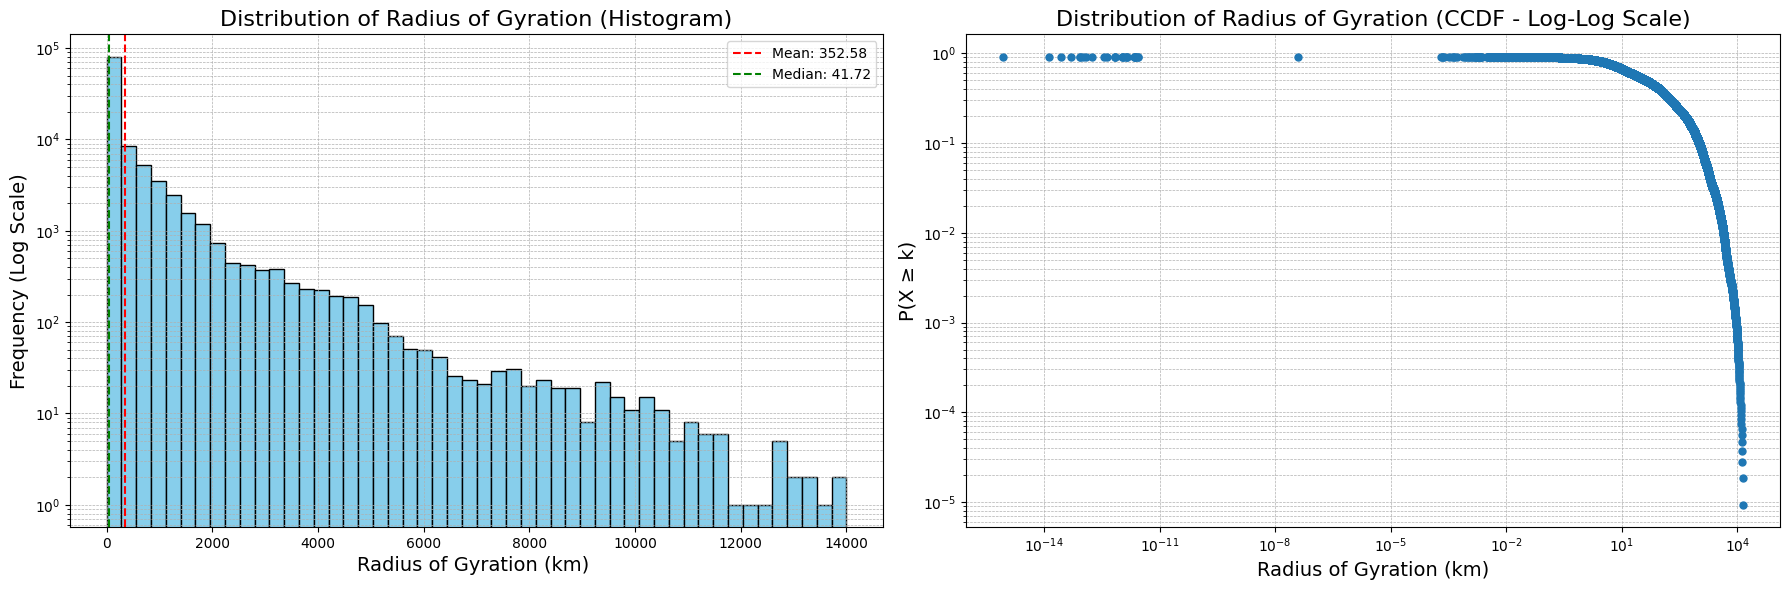

In [41]:
# Plot distribution to understand the measure
plot_distribution(
    users_df['radius_of_gyration_km'],
    'Distribution of Radius of Gyration',
    'Radius of Gyration (km)',
    hist_x_log=False,
    hist_y_log=True
)

The distribution of the radius of gyration is heavily skewed, confirming the existence of both stayers and travelers.  
We can use this measure to validate our initial hypothesis, by checking if there's a correlation between the radius of gyration and the "home-centroid distance" we observed earlier. A strong correlation would confirm that users with large radius of gyration are the same ones whose inferred "home" was far from their activity center.

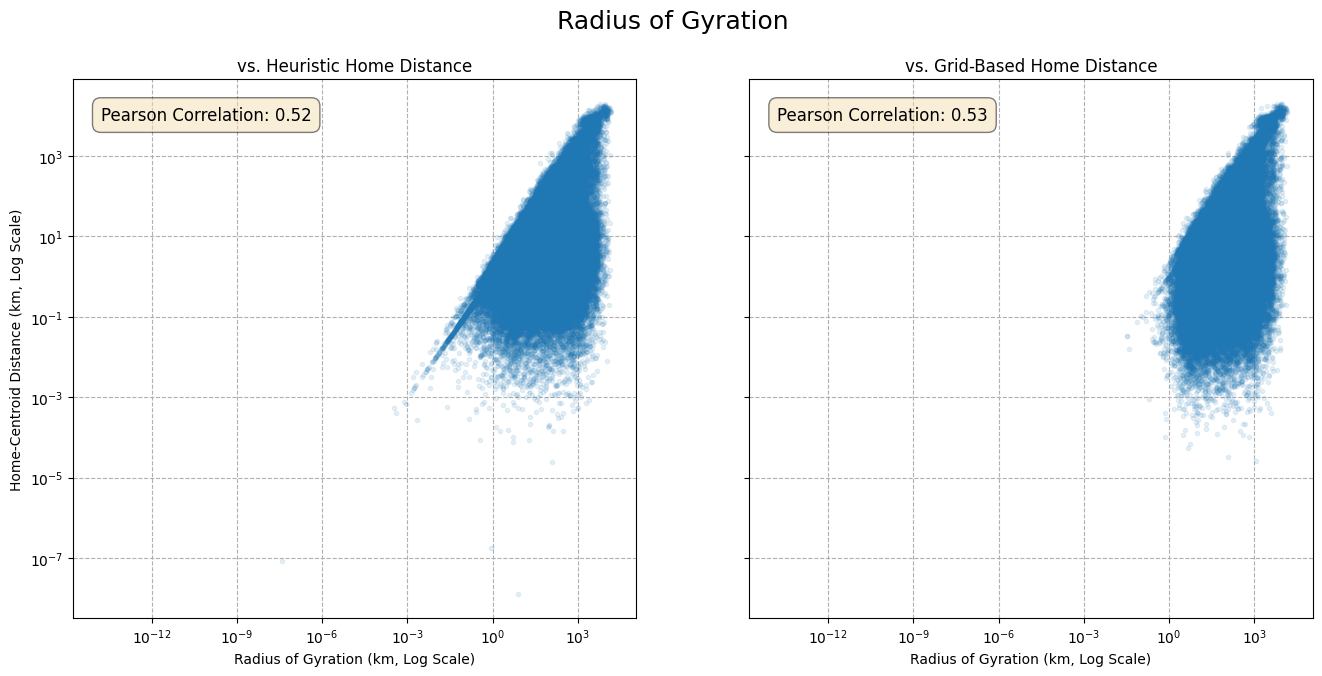

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Radius of Gyration', fontsize=18)

# Plot 1: Correlation with Heuristic-Based Home Distance
corr_heuristic = users_df['radius_of_gyration_km'].corr(users_df['centroid_inferred_home_distance_km'])
ax1.loglog(
    users_df['radius_of_gyration_km'],
    users_df['centroid_inferred_home_distance_km'],
    marker='.', linestyle='none', alpha=0.1
)
ax1.set_title('vs. Heuristic Home Distance')
ax1.set_xlabel('Radius of Gyration (km, Log Scale)')
ax1.set_ylabel('Home-Centroid Distance (km, Log Scale)')
ax1.grid(True, which="both", ls="--")
ax1.text(0.05, 0.95, f'Pearson Correlation: {corr_heuristic:.2f}',
         transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


# Plot 2: Correlation with Grid-Based Home Distance
corr_grid = users_df['radius_of_gyration_km'].corr(users_df['centroid_home_cell_distance_km'])
ax2.loglog(
    users_df['radius_of_gyration_km'],
    users_df['centroid_home_cell_distance_km'],
    marker='.', linestyle='none', alpha=0.1
)
ax2.set_title('vs. Grid-Based Home Distance')
ax2.set_xlabel('Radius of Gyration (km, Log Scale)')
ax2.grid(True, which="both", ls="--")
ax2.text(0.05, 0.95, f'Pearson Correlation: {corr_grid:.2f}',
         transform=ax2.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.show()

Both methods show a similar, moderate positive correlation (`~0.52` and `~0.53`), that validates our initial hypothesis: the engineered features are not an artifact, but both captures an aspect of user mobility.

### Evidence of Homophily

With all the valuable insights discovered, is now the time to search for the evidence that two friend are more similar than non-friend.

#### Proximity: Friends are more likely to live near each other

In [43]:
# Use the best Home estimate
user_locations_df = users_df[['home_cell_centroid_lat', 'home_cell_centroid_lon']].dropna()

In [44]:
# Filter to only include users that have a known home location
valid_users = set(user_locations_df.index)

# Positive Samples
friend_pairs = set([frozenset((u, v)) for u, v in list(G.edges()) if u in valid_users and v in valid_users])
print(f"Found {len(friend_pairs)} ({len(friend_pairs)/G.number_of_edges()*100:.2f}%) friend pairs with known home locations.")

# Negative Samples
non_friend_pairs = uniform_negative_sampling(list(valid_users), friend_pairs, len(friend_pairs), seed=42)
print(f"Found {len(non_friend_pairs)} ({len(non_friend_pairs)/G.number_of_edges()*100:.2f}%) non-friend pairs with known home locations.")

Found 396240 (41.70%) friend pairs with known home locations.
Found 396240 (41.70%) non-friend pairs with known home locations.


In [45]:
def _pairs_haversine_distance(pairs, users_df):
    u_nodes, v_nodes = zip(*[tuple(pair) for pair in pairs])
    u_nodes = list(u_nodes)
    v_nodes = list(v_nodes)

    u_coords = users_df.loc[u_nodes][['home_cell_centroid_lat', 'home_cell_centroid_lon']].to_numpy()
    v_coords = users_df.loc[v_nodes][['home_cell_centroid_lat', 'home_cell_centroid_lon']].to_numpy()
    return haversine_vector(u_coords, v_coords, unit=Unit.KILOMETERS)


friend_distances = _pairs_haversine_distance(friend_pairs, users_df)
non_friend_distances = _pairs_haversine_distance(non_friend_pairs, users_df)

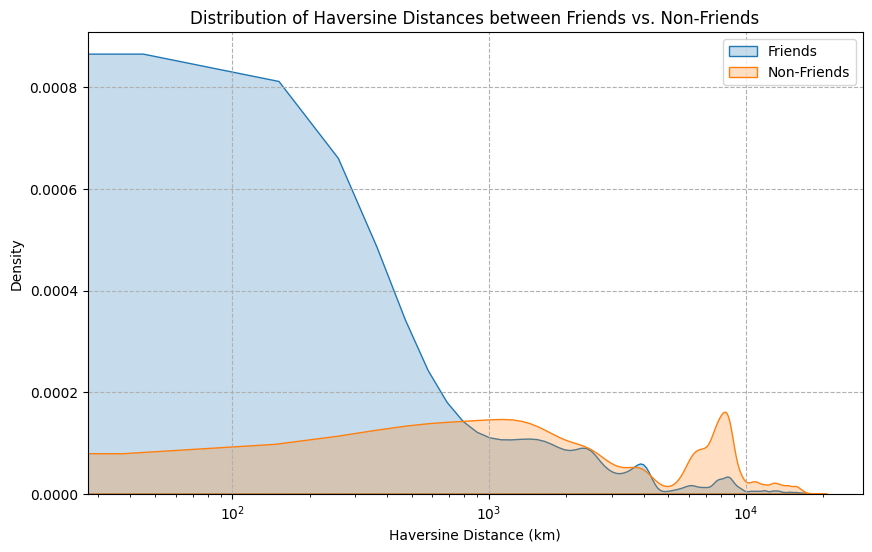

In [46]:
# Plot Distributions
plt.figure(figsize=(10, 6))

sns.kdeplot(friend_distances, fill=True, label='Friends')
sns.kdeplot(non_friend_distances, fill=True, label='Non-Friends')
plt.xscale('log')

plt.xlabel('Haversine Distance (km)')
plt.ylabel('Density')
plt.title('Distribution of Haversine Distances between Friends vs. Non-Friends')
plt.legend()
plt.grid(True, ls="--")

plt.show()

The principle of **proximity (geographic homophily)** was tested by comparing the distribution of Haversine distances between friends and a random sample of non-friends.  
The results show that the probability density for friendships peaks at very short distances and decays rapidly, while the distribution for non-friends is much broader. This clear separation between the two distributions confirms that geographic distance is a powerful predictive feature for link formation in this network and will be a component of the model.

#### Mobility: People with similar mobility patterns are more likely to be friends.

In [47]:
# Filter to only include users that have radius of gyration
user_mobility_df = users_df[['radius_of_gyration_km']].dropna()
valid_mobility_users = set(user_mobility_df.index)

# Positive Sample
friend_pairs_mobility = {pair for pair in friend_pairs if pair.issubset(valid_mobility_users)}
print(f"Found {len(friend_pairs_mobility)} friend pairs where both users have a mobility score.")

# Negative Sample
non_friend_pairs_mobility = [tuple(pair) for pair in non_friend_pairs if frozenset(pair).issubset(valid_mobility_users)]
print(f"Found {len(non_friend_pairs_mobility)} non-friend pairs where both users have a mobility score.")

Found 396240 friend pairs where both users have a mobility score.
Found 396240 non-friend pairs where both users have a mobility score.


In [48]:
# Calculate the absolute difference of radius of gyration
def _calculate_mobility_difference(pairs, user_data):
    u_nodes, v_nodes = zip(*pairs)

    u_mobility = user_data.loc[list(u_nodes)]['radius_of_gyration_km'].values
    v_mobility = user_data.loc[list(v_nodes)]['radius_of_gyration_km'].values

    return np.abs(u_mobility - v_mobility)

friend_mobility_diff = _calculate_mobility_difference(list(friend_pairs_mobility), users_df)
non_friend_mobility_diff = _calculate_mobility_difference(non_friend_pairs_mobility, users_df)

At a difference of 100 km the probability of being friends is: 29.01%
At a difference of 100 km the probability of being non-friends is: 37.89%


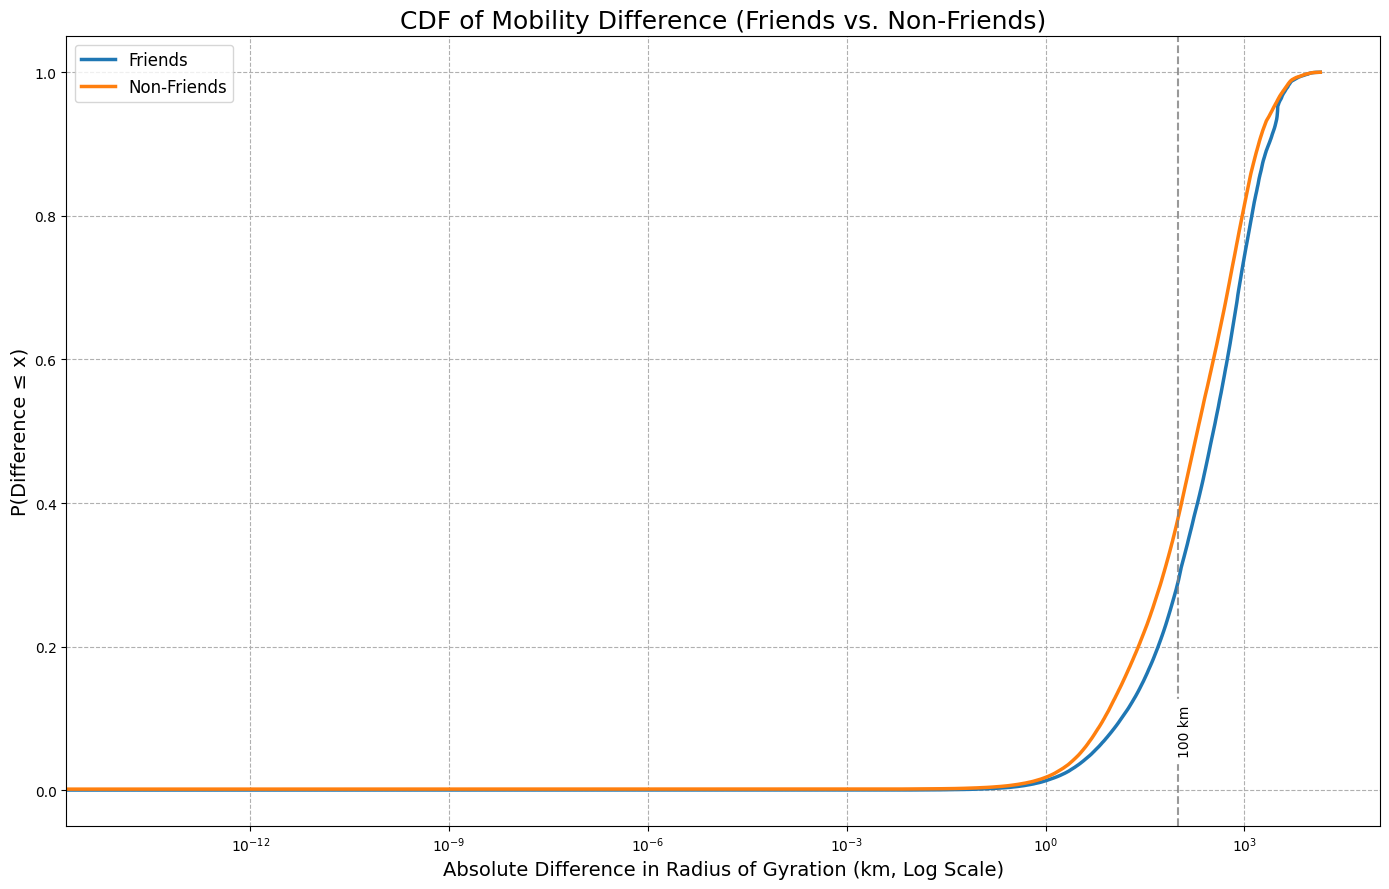

In [49]:
friend_mobility_diff = np.sort(friend_mobility_diff)
non_friend_mobility_diff = np.sort(non_friend_mobility_diff)

y_friend = np.arange(1, len(friend_mobility_diff) + 1) / len(friend_mobility_diff)
y_non_friend = np.arange(1, len(non_friend_mobility_diff) + 1) / len(non_friend_mobility_diff)

plt.figure(figsize=(14, 9))
plt.plot(friend_mobility_diff, y_friend, label='Friends', linewidth=2.5)
plt.plot(non_friend_mobility_diff, y_non_friend, label='Non-Friends', linewidth=2.5)

plt.xscale('log')
plt.title('CDF of Mobility Difference (Friends vs. Non-Friends)', fontsize=18)
plt.xlabel('Absolute Difference in Radius of Gyration (km, Log Scale)', fontsize=14)
plt.ylabel('P(Difference ≤ x)', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, which="both", ls="--")

# Add a vertical indicator at 100 Km for reference
x = 100
plt.axvline(x=x, color='gray', linestyle='--', alpha=0.8)
plt.text(x, 0.05, f'{x} km', rotation=90, backgroundcolor='w')

# Find the cumulative probability at the indicator
prob_friend_at_point = y_friend[np.searchsorted(friend_mobility_diff, x, side='right') - 1]
prob_non_friend_at_point = y_non_friend[np.searchsorted(non_friend_mobility_diff, x, side='right') - 1]

print(f"At a difference of 100 km the probability of being friends is: {prob_friend_at_point*100:.2f}%")
print(f"At a difference of 100 km the probability of being non-friends is: {prob_non_friend_at_point*100:.2f}%")

plt.tight_layout()
plt.show()

The evidence from this plot directly contradicts the initial hypothesis of mobility homophily. Instead of friends having more similar mobility patterns, this data suggests the opposite.  
There is a possible explanation for this phenomenon, still related with the "travel diary" hypothesized before and on how Gowalla really was about: A user who traveled extensively and checked into interesting spots was essentially a *content creator*.

> A "stayer" following a "traveler" on Gowalla is the 2010 equivalent of a regular person following a travel blogger or influencer on Instagram today.

This finding is actually really interesting, because if our initial hypothesis was based on homophily, the same concept in reality represented **heterophily**, where connections form precisely because of the differences between people.

## Saving Results

In [50]:
users_df.to_parquet('data/EDA_output/user_features.parquet')
locations_df.to_parquet('data/EDA_output/location_features.parquet')
df.to_parquet('data/EDA_output/checkins.parquet')